# **DLAI PROJECT**

Project created by Carles Garcia Cabrera (Group 13), student of DLAI during autumm 2019, under the supervison of Noé Casas and Xavier Giró.

The project is broken down in 4 different parts:
  - Exercise 1: Convolutional Autoencoder
  - Exercise 2: Transfer Learning
  - Optional exercise A: Variational Autoencoder
  - Optional exercise B: Conditional GAN

During the whole notebook I will try to explain what I want to do before coding it and along the code I will add very few comments.

**Disclaimer:** While I have been doing the project I have learned some new things that will help me in the future to organise my code better. I have done my best to correct some of the reusage of code but I lacked time to enhance the following code at its best.

# **Let's start!**
First of all the imports for the packages I am going to use:

In [0]:
#Core libraries
import numpy as np
np.random.seed(1)

import torch
import torch.optim as optim
torch.manual_seed(1)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(1)
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from tabulate import tabulate
from statistics import mean

from random import sample, randint

import copy

#GPU Enabling
if not torch.cuda.is_available():
    raise Exception("You should enable GPU in the runtime menu.")
device = torch.device("cuda:0")

# **Exercise 1: Convolutional Autoencoder**
First I will load the **MNIST dataset** and then I will split the trainig data into 95% train and 5% validation.

In [2]:
#Train import
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))
                                    ]))
##Split train into train and val
mnist_trainset, mnist_valset = torch.utils.data.random_split(mnist_trainset, [int(len(mnist_trainset)*0.95),int(len(mnist_trainset)*0.05)])

#Test
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (0.5,))
                               ]))


0it [00:00, ?it/s]

9920512it [00:02, 3861168.52it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 57930.96it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:01, 954069.04it/s]                             
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 21567.90it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


And now the **hyperparametes** that I will use during the exercise:

In [0]:
hparams = {
    'batch_size':128,
    'num_epochs':30,
    'num_epochs2':1000,
    'num_epochs3':500,
    'num_epochs4':2000,
    'test_batch_size':64,
    'hidden1':64,
    'hidden2':128,
    'bottleneck1':20,
    'bottleneck2':50,
    'bottleneck3':100,
    'learning_rate':1e-3,
    'log_interval': 100,
    'num_classes': 10
}
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

And now the **dataloaders**:

In [0]:
train_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

val_loader = torch.utils.data.DataLoader(
    mnist_valset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)

Now I will implement the **autoencoder**:

In [0]:
class autoencoder(nn.Module):
  def __init__(self, hparams, bottleneck):
    super(autoencoder,self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, hparams['hidden1'], 3, stride = 1, padding = 1), 
        nn.ReLU(True),
        nn.MaxPool2d(2),
        nn.Conv2d(hparams['hidden1'], hparams['hidden2'], 3, stride = 1, padding = 1),
        nn.ReLU(True),
        nn.MaxPool2d(2),
    )

    self.linear1 = nn.Linear(hparams['hidden2']*7*7, bottleneck)
    self.linear2 = nn.Linear(bottleneck, hparams['hidden2']*7*7)
    self.linearF = nn.Linear(bottleneck, hparams['num_classes'])
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(hparams['hidden2'], hparams['hidden1'], 4, stride = 2, padding = 1),
        nn.ReLU(True),
        nn.ConvTranspose2d(hparams['hidden1'], 1, 4, stride = 2, padding = 1),
        nn.Tanh()
    )
  
  def forward(self, x):
    x = self.encoder(x)
    #bottleneck
    x = x.view(x.size(0), -1)
    x = self.linear1(x)
    x = self.linear2(x)
    x = x.view(x.size(0), hparams['hidden2'], 7, 7)
    ##
    y = self.decoder(x)
    return y

Now, let's define the **training**:

In [0]:
def train_epoch(train_loader, network, optimizer, criterion, hparams, epoch):
  network.train()
  device = hparams['device']
  losses = []
  for batch_idx, (data, target) in enumerate(train_loader, 1):
      data = data.to(device)
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, data)
      loss.backward()
      losses.append(loss.item())
      optimizer.step()

      if batch_idx % hparams['log_interval'] == 0 or batch_idx >= len(train_loader):
        dataset_length = len(train_loader) * hparams['batch_size']
        processed = batch_idx * hparams['batch_size']
        processed_str = format(processed, '0'+str(len(str(dataset_length))))
        ratio = round((100. * batch_idx / len(train_loader)),0)
        loss_str = str(round(loss.item(),6))
        #print(f"Train Epoch: {epoch} [{processed_str}/{dataset_length} "+\
                  #f"({ratio}%)]\tLoss: {loss_str}")
  return losses

def eval_epoch(val_loader, network, criterion, hparams):
  network.eval()
  device = hparams['device']
  eval_loss = []
  with torch.no_grad():
      for data, target in val_loader:
          data = data.to(device)
          output = network(data)
          e_loss = criterion(output, data).item()
          eval_loss.append(e_loss)
  
  avg_loss = sum(eval_loss) / len(eval_loss)
  val_loss_str = str(round(avg_loss,6))
  #print(f"\nValidation:\t\t\t\tLoss: {val_loss_str} \n\n")
  return avg_loss

def train_net(network, train_loader, eval_loader, optimizer, num_epochs, plot=False):
  tr_losses = []
  te_losses = []
  valid_x = []

  network.to(hparams['device'])
  criterion = nn.MSELoss()

  for epoch in range(1, num_epochs + 1):
    tr_loss = train_epoch(train_loader, network, optimizer, criterion, hparams, epoch)
    te_loss = eval_epoch(eval_loader, network, criterion, hparams)
    tr_losses.extend(tr_loss)
    te_losses.append(te_loss)
    valid_x.append(len(tr_losses)-1)
  
  train_x = range(len(tr_losses))

  rets = {'tr_losses':tr_losses, 'te_losses':te_losses, 'valid_x': valid_x, 'train_x':train_x}
  if plot:
    plt.figure(figsize=(10, 8))
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('NLLLoss')
    plt.plot(tr_losses, label='Train')
    plt.plot(te_losses, label='Eval')
    plt.legend()
  return rets

**Model**, **criterion** and **optimizer**:

In [0]:
#Criterion
criterion = nn.MSELoss()

#Models, optimizers, and model sizes
model1 = autoencoder(hparams, hparams['bottleneck1']).cuda()
optimizer1 = torch.optim.Adam(model1.parameters(), lr = hparams['learning_rate'],
                             weight_decay = 1e-5)
num_params1 = sum(p.numel() for p in model1.parameters() if p.requires_grad)

model2 = autoencoder(hparams, hparams['bottleneck2']).cuda()
optimizer2 = torch.optim.Adam(model2.parameters(), lr = hparams['learning_rate'],
                             weight_decay = 1e-5)
num_params2 = sum(p.numel() for p in model2.parameters() if p.requires_grad)

model3 = autoencoder(hparams, hparams['bottleneck3']).cuda()
optimizer3 = torch.optim.Adam(model3.parameters(), lr = hparams['learning_rate'],
                             weight_decay = 1e-5)
num_params3 = sum(p.numel() for p in model3.parameters() if p.requires_grad)

Let's **TRAIN**

In [0]:
autoen1 = train_net(model1, train_loader, val_loader, optimizer1, hparams['num_epochs'])

In [0]:
autoen2 = train_net(model2, train_loader, val_loader, optimizer2, hparams['num_epochs'])

In [0]:
autoen3 = train_net(model3, train_loader, val_loader, optimizer3, hparams['num_epochs'])

Here can be seen how, the bigger the bottleneck and hence the smaller the compression, the smaller the loss.

Let's **plot** all the curves in the same **chart** to see training performance:

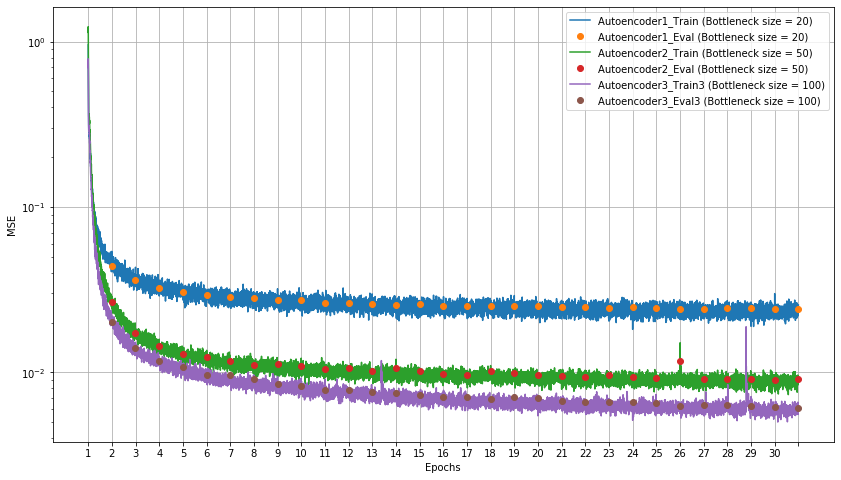

In [11]:
train_x1 = autoen1['train_x']
train_loss1 = autoen1["tr_losses"]
val_x1 = autoen1["valid_x"]
val_loss1 = autoen1["te_losses"]

train_x2 = autoen2['train_x']
train_loss2 = autoen2["tr_losses"]
val_x2 = autoen2["valid_x"]
val_loss2 = autoen2["te_losses"]

train_x3 = autoen3['train_x']
train_loss3 = autoen3["tr_losses"]
val_x3 = autoen3["valid_x"]
val_loss3 = autoen3["te_losses"]

a1 = plt.figure(figsize=(14, 8))
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.plot(train_x1, train_loss1, '-', label='Autoencoder1_Train (Bottleneck size = 20)')
plt.plot(val_x1, val_loss1, 'o', label='Autoencoder1_Eval (Bottleneck size = 20)')
plt.plot(train_x2, train_loss2, '-', label='Autoencoder2_Train (Bottleneck size = 50)')
plt.plot(val_x2, val_loss2, 'o', label='Autoencoder2_Eval (Bottleneck size = 50)')
plt.plot(train_x3, train_loss3, '-', label='Autoencoder3_Train3 (Bottleneck size = 100)')
plt.plot(val_x3, val_loss3, 'o', label='Autoencoder3_Eval3 (Bottleneck size = 100)')

plt.yscale("log")
plt.xticks(np.arange(0, max(train_x1),
                     step=max(train_x1)/hparams['num_epochs']), 
                     [i + 1 for i in range(hparams['num_epochs'])])

plt.grid(True)
plt.legend()
plt.show()

Now I need to define the **testing**, I will compute de **MSE for each image**.

In [0]:
def mse_image(outputs, inputs):
    avg_mse = []
    outputs = outputs.detach().cpu().numpy()
    #Computed for each image and averaged between images
    for input_, output in zip(inputs, outputs):
        mse = (np.square(input_.detach().cpu().numpy() - output)).mean(axis=None)
        avg_mse.append(mse)
    avg_mse = sum(avg_mse) / len(avg_mse)
    return avg_mse

def test_model(network, test_loader):
  network.eval()
  test_loss_avg = 0
  num_batches = 0
  for data, _ in test_loader:
      with torch.no_grad():
          data = data.to(device)
          data_recon = network(data)
          loss = mse_image(data_recon, data)
          #sum for each batch
          test_loss_avg += loss.item()
          num_batches += 1  
  #Mean between batches
  test_loss_avg /= num_batches
  #print('Average Reconstruction Error: %f' % (test_loss_avg))
  return test_loss_avg

And compute the testing over the test set:

In [0]:
test_autoen1 = test_model(model1, test_loader)
test_autoen2 = test_model(model2, test_loader)
test_autoen3 = test_model(model3, test_loader)

**Plotting the results:**

In [14]:
print(tabulate([
                ['Autoencoder1(20)', mean(val_loss1), test_autoen1, num_params1], 
                ['Autoencoder2(50)', mean(val_loss2), test_autoen2, num_params2], 
                ['Autoencoder3(100)', mean(val_loss3), test_autoen3, num_params3]
                ], 
               headers=['Model(Bottleneck size)', 'MSE_val', 'MSE_test', 'Num_params']
               )
)

Model(Bottleneck size)      MSE_val    MSE_test    Num_params
------------------------  ---------  ----------  ------------
Autoencoder1(20)          0.0270238  0.0243728         464039
Autoencoder2(50)          0.0111544  0.00893421        840689
Autoencoder3(100)         0.008198   0.00599393       1468439


Now I will **check how they look like** and compare with our input data.

In [0]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):
    with torch.no_grad():
        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = utils.make_grid(images[0:5],5, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

Using model1(Bottleneck = 20)
---------------------------------
Original images


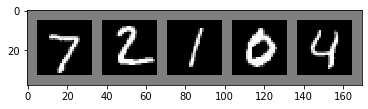

Autoencoder reconstruction:


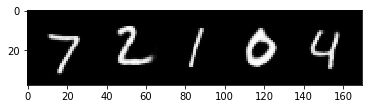

In [16]:
images, _ = iter(test_loader).next()
model1.eval()
print('Using model1(Bottleneck = 20)')
print('---------------------------------')
# First visualise the original images
print('Original images')
show_image(utils.make_grid(images[0:5],5,5))
plt.show()
# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, model1)

What if I **inject noise** in the decoder's input?

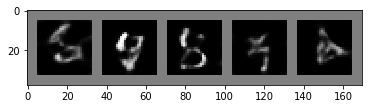

In [17]:
model1.eval()

with torch.no_grad():
  images, labels = iter(test_loader).next()
  images = images.to(device)
  latent = model1.encoder(images)
  latent = latent.view(latent.size(0), -1)
  latent = model1.linear1(latent)
  latent = latent.cpu()

  mean = latent.mean(dim=0)
  std = (latent - mean).pow(2).mean(dim=0).sqrt()

  latent = torch.randn(128, 20)*std + mean

  # reconstruct images from the latent vectors
  latent = latent.to(device)
  img_recon = model1.linear2(latent)
  img_recon = img_recon.view(img_recon.size(0), hparams['hidden2'], 7, 7)
  img_recon = model1.relu(img_recon)
  img_recon = model1.decoder(img_recon)
  img_recon = img_recon.cpu()

  show_image(utils.make_grid(img_recon[:5],5,5))
  plt.show()

# **Exercise 2: Transfer Learning**


In this exercise I will reuse the encoding part of Model1 (Bottleneck = 20) of the exercise 1 to **classify the images into their corresponding number**. To achieve that I will build several approaches and afterwards I will compare them.



First of all I will get a **subset of 100 images** from our training set.

In [0]:
mnist_trainset2, _ = torch.utils.data.random_split(mnist_trainset, [int(len(mnist_trainset)/570),int(len(mnist_trainset)*569/570)])

In [0]:
train_loader2 = torch.utils.data.DataLoader(
    mnist_trainset2,
    batch_size=hparams['batch_size'], 
    shuffle=True)

And I will use, as said, the **model1**(Bottleneck = 20).

In [0]:
ex2model1 = copy.deepcopy(model1)
ex2model2 = copy.deepcopy(model1)
ex2model3 = autoencoder(hparams, hparams['bottleneck1']).cuda()

And now we will create a digit (0-9) classification model **reusing the encoder of the autoencoder** and adding what is needed.

First I **define the training** for this particular problem

In [0]:
def train_epoch2(train_loader, network, optimizer, criterion, hparams, epoch):
  network.train()
  device = hparams['device']
  losses = []
  for batch_idx, (data, target) in enumerate(train_loader, 1):
      data = data.to(device)
      target = target.to(device)
      optimizer.zero_grad()

      #Using the encoder + linear + linear + softmax
      output = network.encoder(data)
      output = output.view(output.size(0), -1)
      output = network.linear1(output)
      output = network.relu(output)
      output = network.linearF(output)
      output = network.softmax(output)

      loss = criterion(output, target)
      loss.backward()
      losses.append(loss.item())
      optimizer.step()
      #if batch_idx % hparams['log_interval'] == 0 or batch_idx >= len(train_loader):
       #   print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #      epoch, batch_idx * len(data), len(train_loader.dataset),
         #     100. * batch_idx / len(train_loader), loss.item()
          #    ))
  return np.mean(losses)

def train_net2(network, train_loader, optimizer, num_epochs, criterion):
  tr_losses = []

  network.to(hparams['device'])

  for epoch in range(1, num_epochs + 1):
    tr_loss = train_epoch2(train_loader, network, optimizer, criterion, hparams, epoch)
    tr_losses.append(tr_loss)
  rets = {'tr_losses':tr_losses}
  return rets

The first approach will be to use **pre-training**, which is using the weights of the autoencoder as initial values for the network weights and train a classification model on the subset of 100 samples.

Criterion and optimizer:

In [0]:
ex2criterion = nn.CrossEntropyLoss()
ex2optimizer1 = torch.optim.Adam(ex2model1.parameters(), lr = hparams['learning_rate'],
                             weight_decay = 1e-5)

Training:

In [23]:
classifier1 = train_net2(ex2model1, train_loader2, ex2optimizer1, hparams['num_epochs2'], ex2criterion)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Now I will use **fine-tuning**, which is doing the same, but training the new projection layer with a normal learning rate and the reused part with a very low learning rate.


In [0]:
ex2optimizer2 = torch.optim.Adam([
    {"params": ex2model2.encoder.parameters(), "lr": 1e-5},
    {"params": ex2model2.linear1.parameters(), "lr": 1e-3},
    {"params": ex2model2.linearF.parameters(), "lr": 1e-3}],
    weight_decay = 1e-5
    )

Training:

In [25]:
classifier2 = train_net2(ex2model2, train_loader2, ex2optimizer2, hparams['num_epochs2'], ex2criterion)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Now I will start **from scratch**, which mean that I will train the model on the 100 samples without reusing the decoder weights at all.

In [0]:
ex2optimizer3 = torch.optim.Adam(ex2model3.parameters(), lr = hparams['learning_rate'],
                             weight_decay = 1e-5)

Training:

In [27]:
classifier3 = train_net2(ex2model3, train_loader2, ex2optimizer3, hparams['num_epochs2'], ex2criterion)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Now let's **test** it:

In [0]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def test_model2(network, test_loader, criterion):
  network.eval()
  test_loss_avg = 0
  num_batches = 0
  acc = 0
  for data, target in test_loader:
      with torch.no_grad():
          data = data.to(device)
          target = target.to(device)

          output = network.encoder(data)
          output = output.view(output.size(0), -1)
          output = network.linear1(output)
          output = network.relu(output)
          output = network.linearF(output)
          output = network.softmax(output)

          acc += correct_predictions(output, target)

          num_batches += 1  
  test_acc = 100. * acc / len(test_loader.dataset)
  #print('Test Acc: %f' % (test_acc))
  return test_acc

Test the 3 different models.

In [29]:
test_classifier1 = test_model2(ex2model1, test_loader, ex2criterion)
test_classifier2 = test_model2(ex2model2, test_loader, ex2criterion)
test_classifier3 = test_model2(ex2model3, test_loader, ex2criterion)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Let's sumarize the results:

In [30]:
print(tabulate([
                ['Pre-training', test_classifier1], 
                ['Fine-tunning', test_classifier2], 
                ['From scratch', test_classifier3]
                ], 
               headers=['Classifier', 'Acc']
               )
)

Classifier      Acc
------------  -----
Pre-training  83.46
Fine-tunning  85.87
From scratch  61.15


# **Optional Exercise A: Variational Autoencoder**

Here I will turn the autoencoder from exercise 1 into a variational autoencoder. Note that I have added Batch Normalisation, I had to try different things because the results were not good enough.

First de **Encoder**

In [0]:
class VARencoder(nn.Module):
  def __init__(self, hparams, bottleneck):
    super(VARencoder, self).__init__()

    self.bottleneck = bottleneck

    self.convs = nn.Sequential(
        nn.Conv2d(1, hparams['hidden1'], 3, stride = 1, padding = 1),
        nn.BatchNorm2d(hparams['hidden1']), 
        nn.ReLU(True),
        nn.MaxPool2d(2),
        nn.Conv2d(hparams['hidden1'], hparams['hidden2'], 3, stride = 1, padding = 1),
        nn.BatchNorm2d(hparams['hidden2']),
        nn.ReLU(True),
        nn.MaxPool2d(2),
    )

    self.linear1 = nn.Linear(hparams['hidden2']*7*7, bottleneck)
    self.linear2 = nn.Linear(hparams['hidden2']*7*7, bottleneck)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.convs(x)

    x = x.view(x.size(0), -1)

    mu = self.linear1(x)
    mu = self.relu(mu)

    logvar = self.linear2(x)
    logvar = self.relu(logvar)

    return mu, logvar

Next the **decoder**

In [0]:
class VARdecoder(nn.Module):
  def __init__(self, hparams, bottleneck):
    super(VARdecoder, self).__init__()

    self.bottleneck = bottleneck

    self.convs = nn.Sequential(
        nn.ConvTranspose2d(hparams['hidden2'], hparams['hidden1'], 4, stride = 2, padding = 1),
        nn.BatchNorm2d(hparams['hidden1']),
        nn.ReLU(True),
        nn.ConvTranspose2d(hparams['hidden1'], 1, 4, stride = 2, padding = 1),
        nn.BatchNorm2d(1),
        nn.Tanh()
    )

    self.linear = nn.Linear(bottleneck, hparams['hidden2']*7*7)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.linear(x)
    x = self.relu(x)
    x = x.view(x.size(0), hparams['hidden2'], 7, 7)
    x = self.convs(x)
    return x

And now the whole **autoencoder**

In [0]:
class VARautoencoder(nn.Module):
  def __init__(self, hparams, bottleneck, num_z):
    super(VARautoencoder,self).__init__()
    self.encoder = VARencoder(hparams, bottleneck)
    self.decoder = VARdecoder(hparams, bottleneck)
    self.num_z = num_z

  def reparametrize(self, mu, logvar):
      if self.training:
        z = []
        for i in range(self.num_z):
          std = logvar.mul(0.5).exp_()
          eps = torch.cuda.FloatTensor(std.size()).normal_()
          eps = Variable(eps)
          z.append(eps.mul(std).add_(mu)) 
        return z
      else: 
        return mu

  def loss_function(self, recon_x, x, mu, logvar):
    reconstruction_error = nn.MSELoss()
    reconstruction_error.size_average = False
    BCE = 0
    if self.training:
      for y in recon_x:
        BCE += reconstruction_error(y,x)
      BCE /= len(recon_x)
    else:
      BCE += reconstruction_error(recon_x,x)

    KLD = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    #KLD = torch.sum(KLD_element).mul_(-0.5)
    KLD /= int(x.view(-1).shape[0])
    return BCE + KLD

  def forward(self,x):
    mu, logvar = self.encoder(x)
    z = self.reparametrize(mu, logvar)
    if self.training:
      return [self.decoder(z) for z in z], mu, logvar
    else:
      return self.decoder(z), mu, logvar

Now I define the **training** again, because there some minor changes. Not the best practices but I did not have time to wrap it all up in just one proper and unique training definition.

In [0]:
def train_epochVar(train_loader, network, optimizer, hparams, epoch):
  network.train()
  device = hparams['device']
  losses = []
  for batch_idx, (data, target) in enumerate(train_loader, 1):
      data = data.to(device)
      optimizer.zero_grad()

      output, mu, logvar = network(data)

      loss = network.loss_function(output, data, mu, logvar)
      loss.backward()
      losses.append(loss.item())
      optimizer.step()

      if batch_idx % hparams['log_interval'] == 0 or batch_idx >= len(train_loader):
        dataset_length = len(train_loader) * hparams['batch_size']
        processed = batch_idx * hparams['batch_size']
        processed_str = format(processed, '0'+str(len(str(dataset_length))))
        ratio = round((100. * batch_idx / len(train_loader)),0)
        loss_str = str(round(loss.item(),6))
        #print(f"Train Epoch: {epoch} [{processed_str}/{dataset_length} "+\
                  #f"({ratio}%)]\tLoss: {loss_str}")
  return losses

def eval_epochVar(val_loader, network, hparams):
  network.eval()
  device = hparams['device']
  eval_loss = []
  with torch.no_grad():
      for data, target in val_loader:
          data = data.to(device)
          output, mu, logvar = network(data)
          e_loss = network.loss_function(output, data, mu, logvar).item()
          eval_loss.append(e_loss)
  
  avg_loss = sum(eval_loss) / len(eval_loss)
  val_loss_str = str(round(avg_loss,6))
  #print(f"\nValidation:\t\t\t\tLoss: {val_loss_str} \n\n")
  return avg_loss

def train_netVar(network, train_loader, eval_loader, optimizer, num_epochs, plot=False):
  tr_losses = []
  te_losses = []
  valid_x = []

  network.to(hparams['device'])
  criterion = nn.MSELoss()

  for epoch in range(1, num_epochs + 1):
    tr_loss = train_epochVar(train_loader, network, optimizer, hparams, epoch)
    te_loss = eval_epochVar(eval_loader, network, hparams)
    tr_losses.extend(tr_loss)
    te_losses.append(te_loss)
    valid_x.append(len(tr_losses)-1)
  
  train_x = range(len(tr_losses))

  rets = {'tr_losses':tr_losses, 'te_losses':te_losses, 'valid_x': valid_x, 'train_x':train_x}
  if plot:
    plt.figure(figsize=(10, 8))
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('NLLLoss')
    plt.plot(tr_losses, label='Train')
    plt.plot(te_losses, label='Eval')
    plt.legend()
  return rets

**Model** and **optimizer**

In [0]:
modelVar = VARautoencoder(hparams, hparams['bottleneck1'], num_z = 15).cuda()
optimizerVar = torch.optim.Adam(modelVar.parameters(), lr = hparams['learning_rate'],
                             weight_decay = 1e-5)

**Training**

In [0]:
VARautoen = train_netVar(modelVar, train_loader, val_loader, optimizerVar, hparams['num_epochs'])

I define a function for being able to visualize the outputs:

In [0]:
def visualise_output2(images, model):
    with torch.no_grad():
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = utils.make_grid(images[5:10],5, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

And now I use it to **see the reconstruction**

Using (Bottleneck = 20)
---------------------------------
Original images


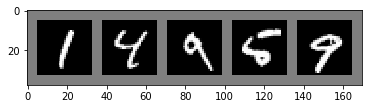

Autoencoder reconstruction:


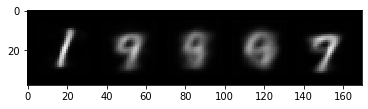

In [38]:
images, _ = iter(test_loader).next()
modelVar.eval()
print('Using (Bottleneck = 20)')
print('---------------------------------')
# First visualise the original images
print('Original images')
show_image(utils.make_grid(images[5:10],5,5))
plt.show()
# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output2(images, modelVar)

Finally, I check what is the output when **injecting a random input** to the decoder.

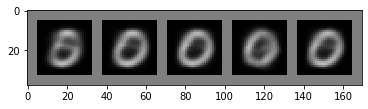

In [39]:
modelVar.eval()

latent = torch.randn(5, hparams['bottleneck1'])
output = modelVar.decoder(latent.to(device))
output = output.detach().cpu()

show_image(utils.make_grid(output[:5],5,5))
plt.show()
